In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import operator
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [4]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [5]:
structured_output = model.with_structured_output(TweetEvaluation)

In [6]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iterations: int

    generated_tweets : Annotated[list[str], operator.add]
    generated_feedbacks : Annotated[list[str], operator.add]


In [7]:
def generate_tweet(state: TweetState) -> TweetState:
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english
    """)
    ]

    response = model.invoke(messages).content


    return { 'tweet': response, 'generated_tweets': [response] }


In [8]:
def evaluate_tweet(state: TweetState) -> TweetState:

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality – Is this fresh, or have you seen it a hundred times before?  
    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness – Is it short, sharp, and scroll-stopping?  
    4. Virality Potential – Would people retweet or share it?  
    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]

    response = structured_output.invoke(messages)

    return {
        'evaluation': response.evaluation,
        'feedback': response.feedback,
        'generated_feedbacks': [response.feedback]
    }



In [9]:
def optimize_tweet(state: TweetState) -> TweetState:
    # prompt
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = model.invoke(messages).content
    iteration = state['iteration'] + 1

    return { 'tweet': response, 'iteration': iteration , 'generated_tweets': [response] }

In [10]:
def route_evaluation(state: TweetState) -> str:
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

In [11]:
graph = StateGraph(TweetState)

# Adding nodes to the graph
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimise', optimize_tweet)

# Adding edges to the graph
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation, {"approved": END, "needs_improvement": 'optimise'})
graph.add_edge('optimise', 'evaluate')

workflow = graph.compile()



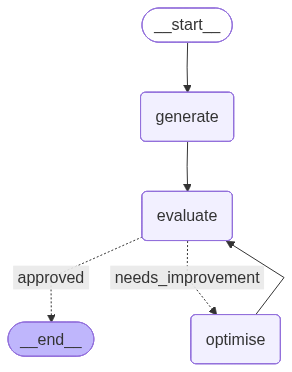

In [12]:
workflow

In [15]:
initial_state = {
    "topic": "abcabc",
    "iteration": 1,
    "max_iterations": 5
}
result = workflow.invoke(initial_state)

In [16]:
result

{'topic': 'abcabc',
 'tweet': "My brain's ability to forget a newly created password in 5 minutes deserves an Olympic medal.",
 'evaluation': 'approved',
 'feedback': 'This tweet effectively captures a universally relatable frustration with a concise and humorous comparison to an "Olympic medal." Its brevity and directness make it highly punchy and scroll-stopping, ensuring strong virality potential as many users will identify with the sentiment. While the core idea of forgetting passwords isn\'t entirely novel, the specific phrasing elevates it beyond a generic complaint, making it an approved tweet.',
 'iteration': 2,
 'max_iterations': 5,
 'generated_tweets': ['My brain trying to remember the password I just created 5 minutes ago: "abcabc... no, wait, was it abcaBC? Or ABCabc? Guess I\'m locked out forever now."',
  "My brain's ability to forget a newly created password in 5 minutes deserves an Olympic medal."],
 'generated_feedbacks': ["This tweet captures a universally relatable s